![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [6]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [7]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

<Axes: title={'center': 'Sentiminetos por aerolínea'}, xlabel='airline'>

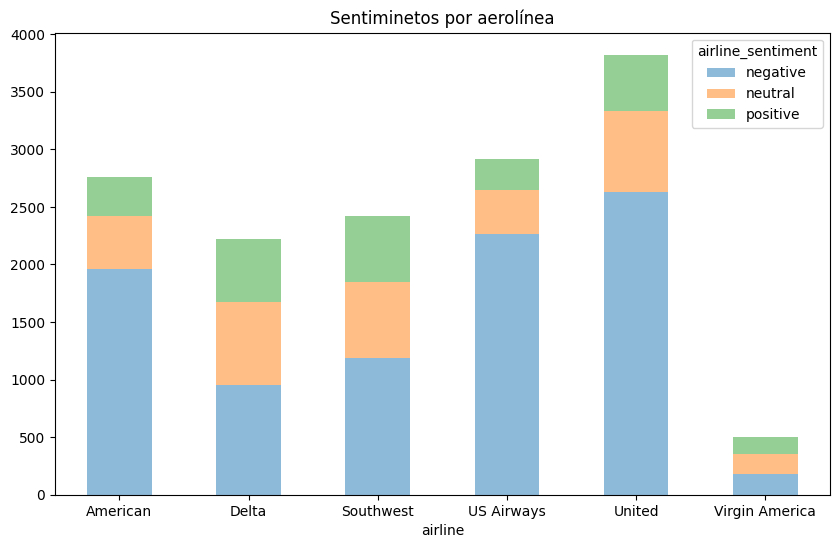

In [8]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

### Liberias y Variables de interés y predicción

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score

from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score
import numpy as np
import re
import unidecode
import emoji

In [10]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [11]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
def limpiar_texto(txt):
    res = re.sub(r'http\S+', '', txt)
    res = re.sub(r'@\w+', '', res)
    res = re.sub(r'#\w+', '', res)
    res = unidecode.unidecode(res)
    res = re.sub(r'\s+', ' ', res).strip()
    res = emoji.demojize(res, delimiters=("", " "))
    return res

X_train = X_train.apply(limpiar_texto)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [14]:
pipeline = Pipeline([
    ('vect', CountVectorizer(lowercase=False)),
    ('clf', RandomForestClassifier(random_state=42))
])
params = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'clf__n_estimators': np.arange(100, 1001, 100),
    'clf__max_depth': [None] + list(np.arange(5, 51, 5)),
    'clf__min_samples_split': np.arange(2, 11, 2)
}
random_search_p1 = RandomizedSearchCV(
    pipeline,
    params,
    n_iter=40,
    cv=3,
    scoring=make_scorer(accuracy_score), 
    random_state=42,
    verbose=2 
)
random_search_p1.fit(X_train,y_train)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END clf__max_depth=35, clf__min_samples_split=4, clf__n_estimators=300, vect__ngram_range=(1, 4); total time=  22.9s
[CV] END clf__max_depth=35, clf__min_samples_split=4, clf__n_estimators=300, vect__ngram_range=(1, 4); total time=  25.9s
[CV] END clf__max_depth=35, clf__min_samples_split=4, clf__n_estimators=300, vect__ngram_range=(1, 4); total time=  51.6s
[CV] END clf__max_depth=30, clf__min_samples_split=8, clf__n_estimators=400, vect__ngram_range=(1, 3); total time=  28.7s
[CV] END clf__max_depth=30, clf__min_samples_split=8, clf__n_estimators=400, vect__ngram_range=(1, 3); total time=  28.8s
[CV] END clf__max_depth=30, clf__min_samples_split=8, clf__n_estimators=400, vect__ngram_range=(1, 3); total time=  30.2s
[CV] END clf__max_depth=40, clf__min_samples_split=10, clf__n_estimators=100, vect__ngram_range=(1, 2); total time=   8.9s
[CV] END clf__max_depth=40, clf__min_samples_split=10, clf__n_estimators=100, vect_

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(lowercase=False)),
                                             ('clf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=40,
                   param_distributions={'clf__max_depth': [None, 5, 10, 15, 20,
                                                           25, 30, 35, 40, 45,
                                                           50],
                                        'clf__min_samples_split': array([ 2,  4,  6,  8, 10]),
                                        'clf__n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                                        'vect__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (1, 4)]},
                   random_state=42,
                   scoring=make_scorer(accuracy_score, response_method='predict'),
                   verbose=2)

In [18]:
print("Mejor Accuracy en train: %s" % random_search_p1.best_score_)
print("Mejores Parámetros: %s" % random_search_p1.best_params_)

Mejor Accuracy en train: 0.7296074482153888
Mejores Parámetros: {'vect__ngram_range': (1, 2), 'clf__n_estimators': 800, 'clf__min_samples_split': 2, 'clf__max_depth': None}


In [19]:
vect_p1 = CountVectorizer(lowercase=False,ngram_range=(1, 2))
X_train_p1 = vect_p1.fit_transform(X_train)
rf_p1 = RandomForestClassifier(n_estimators=800,min_samples_split=2,max_depth=None,random_state=42)
rf_p1.fit(X_train_p1, y_train)

RandomForestClassifier(n_estimators=800, random_state=42)

In [20]:
X_test_p1 = X_test.apply(limpiar_texto)

In [26]:
X_test_p1 = vect_p1.transform(X_test)
y_pred_p1 = rf_p1.predict(X_test_p1)
accuracy_p1 = accuracy_score(y_test, y_pred_p1)
print(f"Accuracy CountVectorizers: {accuracy_p1}")

Accuracy CountVectorizers: 0.765728476821192


En principio se quitaron enlaces, menciones y hashtags de los textos de cada tweet, además de una limpieza de caracteres y extracción de texto de los emojis en éstos. Posteriormente se realizó una busqueda aleatoria de parámetros (40 iteraciones y 3 folds para la validación cruzada de cada uno) cuyo resultado fue el siguiente: n_estimators=800, min_samples_split=2, max_depth=None (para el Random Forest) y ngram_range=(1, 2) (para el CountVectorizer). Se entrenó un modelo con los parámetros encontrados y finalmente se realizó una predicción con la muestra de test (luego de aplicar la misma limpieza) con un resultado de Accuracy de 75.84%, lo que indica que el modelo fue capaz de clasificar correctamente tres cuartas partes del conjunto de prueba.

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [31]:
# Crear un vectorizador CountVectorizer sin stopwords
vect_no_stopw = CountVectorizer(stop_words='english')

In [32]:
# Impresión de stopwords del texto
print(vect_no_stopw.get_stop_words())

frozenset({'alone', 'give', 'six', 'still', 'within', 'yourselves', 'sometime', 'this', 'how', 'keep', 'thick', 'ten', 'across', 'seeming', 'ltd', 'you', 'meanwhile', 'very', 'be', 'fifty', 'fifteen', 'hasnt', 'toward', 'me', 'five', 'or', 'it', 'front', 'who', 'bottom', 'next', 'fill', 'now', 'not', 'and', 'over', 'name', 'out', 'could', 'by', 'in', 'thus', 'yet', 'describe', 'ie', 'hundred', 'always', 'every', 'to', 'behind', 'amount', 'whatever', 'something', 'mill', 'too', 'him', 'above', 'their', 'have', 'yourself', 'already', 'perhaps', 'they', 'nine', 'thru', 'also', 'would', 'cannot', 'together', 'up', 'amongst', 'beyond', 'many', 'themselves', 'system', 'move', 'about', 'everything', 'most', 'forty', 'somewhere', 'becoming', 'itself', 'at', 'the', 'whenever', 'found', 'all', 'yours', 'that', 'well', 'nor', 'thence', 'was', 'put', 'hereby', 'herself', 'first', 'whereupon', 'her', 'two', 'if', 'fire', 'get', 'a', 'anywhere', 'sometimes', 'from', 'afterwards', 'being', 'nothing',

In [33]:
X_train_vect = vect_no_stopw.fit_transform(X_train)
X_test_vect = vect_no_stopw.transform(X_test)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_vect, y_train)

y_pred = clf.predict(X_test_vect)

# Desempeño del modelo sin considerar stopwords
accuracy_p2 = accuracy_score(y_test, y_pred)
print(f"Accuracy sin considerar stopwords: {accuracy_p2}")

Accuracy sin considerar stopwords: 0.7601407284768212


Para la eliminación de stopwords se ajustaron los datos de entrenamiento con CountVectorizer (vect_no_stopw) con stop_words='english' para eliminar stopwords del texto durante el proceso de tokenización y vectorización, luego hicimos fit_transform() al conjunto de entrenamiento (X_train) utilizando vect_no_stopw para aprender el vocabulario y transformar los datos en una matriz de términos de documento sin stopwords, luego usamos transform() en el conjunto de prueba (X_test) para aplicar la misma transformación basada en el vocabulario aprendido del conjunto de entrenamiento. 

Por ultimo se entrenó un modelo con los parámetros encontrados y se realizó una predicción con la muestra de test sin considerar stopwords,donde se obtuvo un accuracy de 76.01% en el conjunto de prueba, lo que nos dice que aproximadamente tres cuartas partes de las predicciones realizadas por el modelo coinciden con las etiquetas reales de sentimiento de los tweets en el conjunto de prueba.

### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [22]:
# Celda 3

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

X_train_p3 = X_train.apply(limpiar_texto)
X_test_p3 = X_test.apply(limpiar_texto)


In [23]:
def split_into_lemmas(text):
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word,pos='v') for word in words]

vect_lemas = CountVectorizer(analyzer=split_into_lemmas)

In [24]:
X_dtm_3_train = vect_lemas.fit_transform(X_train_p3)

In [25]:
params = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None] + list(np.arange(5, 51, 5)),
    'min_samples_split': np.arange(2, 11, 2)
}
random_search_p3 = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    params,
    n_iter=40,
    cv=3,
    scoring=make_scorer(accuracy_score), 
    random_state=42,
    verbose=2 
)
random_search_p3.fit(X_dtm_3_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END max_depth=15, min_samples_split=10, n_estimators=600; total time=  12.8s
[CV] END max_depth=15, min_samples_split=10, n_estimators=600; total time=  15.7s
[CV] END max_depth=15, min_samples_split=10, n_estimators=600; total time=  10.9s
[CV] END max_depth=5, min_samples_split=6, n_estimators=1000; total time=   6.0s
[CV] END max_depth=5, min_samples_split=6, n_estimators=1000; total time=   5.9s
[CV] END max_depth=5, min_samples_split=6, n_estimators=1000; total time=   5.9s
[CV] END max_depth=45, min_samples_split=8, n_estimators=100; total time=   5.4s
[CV] END max_depth=45, min_samples_split=8, n_estimators=100; total time=   5.6s
[CV] END max_depth=45, min_samples_split=8, n_estimators=100; total time=   5.6s
[CV] END max_depth=10, min_samples_split=2, n_estimators=1000; total time=  11.9s
[CV] END max_depth=10, min_samples_split=2, n_estimators=1000; total time=  12.0s
[CV] END max_depth=10, min_samples_split=2

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=40,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20, 25,
                                                      30, 35, 40, 45, 50],
                                        'min_samples_split': array([ 2,  4,  6,  8, 10]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                   random_state=42,
                   scoring=make_scorer(accuracy_score, response_method='predict'),
                   verbose=2)

In [27]:
print("Mejor Accuracy en train: %s" % random_search_p3.best_score_)
print("Mejores Parámetros: %s" % random_search_p3.best_params_)

Mejor Accuracy en train: 0.7265488141310783
Mejores Parámetros: {'n_estimators': 700, 'min_samples_split': 2, 'max_depth': None}


In [28]:
rf_p3 = RandomForestClassifier(n_estimators=700,min_samples_split=2,max_depth=None,random_state=42)
rf_p3.fit(X_dtm_3_train, y_train)

RandomForestClassifier(n_estimators=700, random_state=42)

In [29]:
X_test_p3 = vect_lemas.transform(X_test_p3)
y_pred_p3 = rf_p3.predict(X_test_p3)
accuracy_p3 = accuracy_score(y_test, y_pred_p3)
print(f"Accuracy Lematización con verbos: {accuracy_p3}")

Accuracy Lematización con verbos: 0.7531043046357616


Se inicia aplicando la función limpiar_texto a las muestras X de entrenamiento y prueba. Adicionalmente, se crea la función split_into_lemmas, que se encarga de tomar los textos, dividirlos y aplicarles la lematización. Luego se hace una búsqueda de hiperparámetros para el modelo de Random Forest: 'n_estimators': 700, 'min_samples_split': 2. Luego se entrena el modelo con los datos de entrenamiento lematizados, posteriormente se obtienen resultados utilizando los datos de prueba lematizados, obteniendo un acurrancy de 0.7531.

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [36]:
# Definir función para lematizar verbos
def split_into_lemmas(text):
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]

# Crear instancia de WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Crear instancia de CountVectorizer con eliminación de stopwords y lematización de verbos
vect_multiple_tec = CountVectorizer(stop_words='english', analyzer=split_into_lemmas)

# Aplicar CountVectorizer a los datos de entrenamiento y transformarlos
X_train_dtm_multiple_tec = vect_multiple_tec.fit_transform(X_train)

# Aplicar CountVectorizer transformado a los datos de prueba
X_test_dtm_multiple_tec = vect_multiple_tec.transform(X_test)

# Definir parámetros para la búsqueda aleatoria de hiperparámetros
params = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None] + list(np.arange(5, 51, 5)),
    'min_samples_split': np.arange(2, 11, 2)
}

# Configurar RandomizedSearchCV para encontrar los mejores hiperparámetros
random_search_multiple_tec = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    params,
    n_iter=40,
    cv=3,
    scoring='accuracy', 
    random_state=42,
    verbose=2 
)

# Entrenar el modelo utilizando RandomizedSearchCV en los datos de entrenamiento transformados
random_search_multiple_tec.fit(X_train_dtm_multiple_tec, y_train)

# Obtener el mejor modelo y los mejores parámetros encontrados
best_rf_model_multiple_tec = random_search_multiple_tec.best_estimator_
best_params_multiple_tec = random_search_multiple_tec.best_params_

# Imprimir los mejores parámetros encontrados
print("Mejores Parámetros:")
print(best_params_multiple_tec)

# Predecir sobre los datos de prueba transformados
y_pred_multiple_tec = best_rf_model_multiple_tec.predict(X_test_dtm_multiple_tec)

# Calcular la precisión del modelo en el conjunto de prueba
accuracy_multiple_tec = accuracy_score(y_test, y_pred_multiple_tec)
print("Accuracy en Test:", accuracy_multiple_tec)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END max_depth=15, min_samples_split=10, n_estimators=600; total time=  13.7s
[CV] END max_depth=15, min_samples_split=10, n_estimators=600; total time=  14.8s
[CV] END max_depth=15, min_samples_split=10, n_estimators=600; total time=  10.6s
[CV] END max_depth=5, min_samples_split=6, n_estimators=1000; total time=   6.2s
[CV] END max_depth=5, min_samples_split=6, n_estimators=1000; total time=   6.2s
[CV] END max_depth=5, min_samples_split=6, n_estimators=1000; total time=   6.0s
[CV] END max_depth=45, min_samples_split=8, n_estimators=100; total time=   5.4s
[CV] END max_depth=45, min_samples_split=8, n_estimators=100; total time=   5.5s
[CV] END max_depth=45, min_samples_split=8, n_estimators=100; total time=   5.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=1000; total time=  12.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=1000; total time=  12.3s
[CV] END max_depth=10, min_samples_split=2

### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

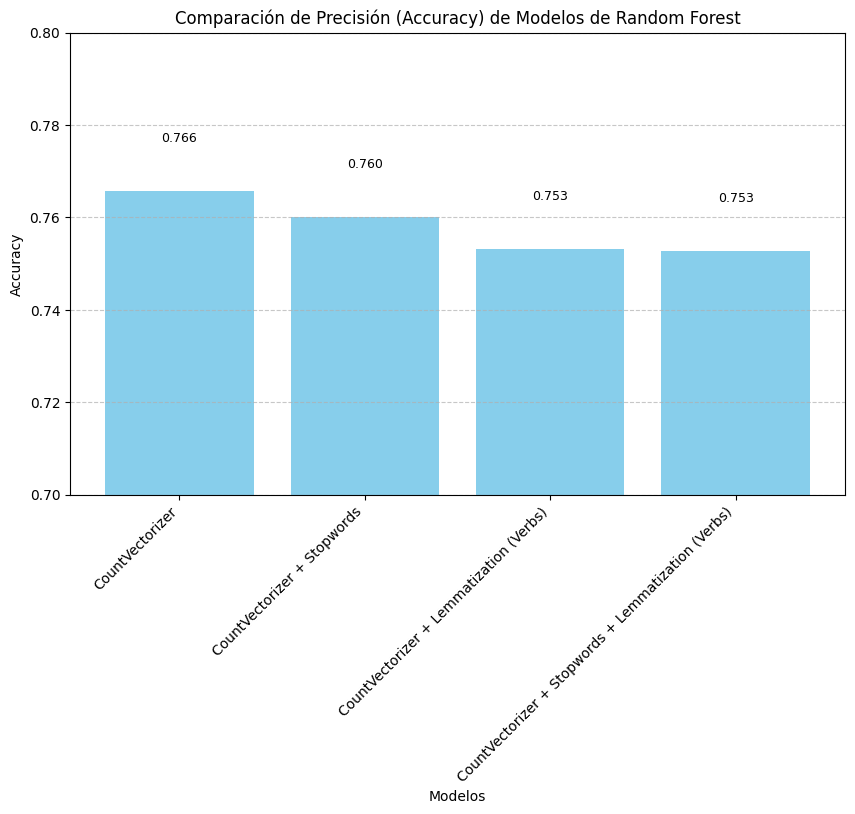

In [38]:
model_names = ['CountVectorizer', 'CountVectorizer + Stopwords', 'CountVectorizer + Lemmatization (Verbs)',
               'CountVectorizer + Stopwords + Lemmatization (Verbs)']

# Lista de accuracy de cada modelo
accuracies = [accuracy_p1, accuracy_p2, accuracy_p3, accuracy_multiple_tec]

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='skyblue')

# Agregar etiquetas (números) sobre cada barra
for bar, accuracy in zip(bars, accuracies):
    yval = accuracy + 0.01  # Ajustar la posición vertical de la etiqueta
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{accuracy:.3f}', ha='center', va='bottom', fontsize=9)

plt.title('Comparación de Precisión (Accuracy) de Modelos de Random Forest')
plt.xlabel('Modelos')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.8)  # Ajustar límites del eje y para mejor visualización
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mejor visualización
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Agregar rejilla horizontal
plt.show()

